# Peak Set x Affinity

Break down of affinities for transient motifs by peak set.

**Inputs**:
1. Motif scans, filtered to important instances, along with log-odds scores for each peak set.
2. Peak set BED files.

In [1]:
library(GenomicRanges)
library(ggplot2)
library(patchwork)
library(ggpubr)

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The

## Load Input Data

### Peak Sets

In [39]:
PEAK_SET_BASE = "/users/surag/kundajelab/scATAC-reprog/src/analysis/20200307_fine_clustering/beds/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/"
PEAK_SET_BASE

[1] "/users/surag/kundajelab/scATAC-reprog/src/analysis/20200307_fine_clustering/beds/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/"

In [42]:
PEAK_SETS = c("6", "7", "8", "early_on")

In [43]:
peak_sets_granges = list()
for (i in PEAK_SETS[1:3]) {
    cur =  read.table(sprintf("%s/idx%s.bed", PEAK_SET_BASE, i))
    colnames(cur) = c("chr", "start", "end")
    peak_sets_granges[[i]] = GRanges(cur)
}

In [46]:
peak_sets_granges[["6"]]

GRanges object with 30214 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
      [1]    chr17 54965839-54966339      *
      [2]    chr17 31353882-31354382      *
      [3]    chr17 62938262-62938762      *
      [4]    chr17 29952043-29952543      *
      [5]    chr17 13695960-13696460      *
      ...      ...               ...    ...
  [30210]     chrY 13356759-13357259      *
  [30211]     chrY 14788610-14789110      *
  [30212]     chrY 18835883-18836383      *
  [30213]     chrY 13337357-13337857      *
  [30214]     chrY 13241191-13241691      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [47]:
early_on_peaks = read.table("./early_on.bed")
colnames(early_on_peaks) = c("chr", "start", "end")
peak_sets_granges[["early_on"]] = GRanges(early_on_peaks)

## Motif Scans

In [146]:
MOTIF_SCAN_BASE="./motif_scans/scans/"

In [147]:
MOTIFS = c("OCTSOX", "SOX.not.OCTSOX", "KLF","AP1.not.OCTSOX")

In [148]:
imp_thresh_motif_hits = list()

for (x in MOTIFS) {
    cur = read.table(sprintf("%s/importance_thresholded/%s.tsv", MOTIF_SCAN_BASE, x), header=T)
    
    imp_thresh_motif_hits[[x]] = GRanges(cur)
}

In [150]:
head(imp_thresh_motif_hits[["OCTSOX"]])

GRanges object with 6 ranges and 3 metadata columns:
      seqnames            ranges strand |     score              seq
         <Rle>         <IRanges>  <Rle> | <numeric>         <factor>
  [1]    chr17 20216024-20216039      - |  5.219048 TGCTGCATAATAACAG
  [2]    chr17 20216067-20216082      - |  9.142086 ATTAACATATGAAGAG
  [3]    chr17 33487642-33487657      - |  5.217108 ATTAACATTTGAGTCA
  [4]    chr17     525382-525397      - | 10.497469 CTTTACATAAAAATGA
  [5]    chr17 20480405-20480420      + |  5.626745 ATATTCTAATGCACTC
  [6]    chr17 37812658-37812673      - |  8.180477 TTTTACATGAGAATCT
                    imp
              <numeric>
  [1] 0.509488618001342
  [2] 0.948824319988489
  [3] 0.760229187086225
  [4] 0.579924593679607
  [5] 0.406691043594037
  [6]  1.00784254074097
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [143]:
names(imp_thresh_motif_hits)

[1] "OCTSOX"         "SOX.not.OCTSOX" "KLF"            "AP1.not.OCTSOX"

In [152]:
raw_motif_hits = list()

for (x in MOTIFS) {
    cur = read.table(sprintf("%s/raw/%s.bed", MOTIF_SCAN_BASE, x), header=T)
    colnames(cur) = c("chr", "start", "end", "strand", "score", "seq")
    
    raw_motif_hits[[x]] = GRanges(cur)
}

In [153]:
head(raw_motif_hits[["OCTSOX"]])

GRanges object with 6 ranges and 2 metadata columns:
      seqnames            ranges strand |     score              seq
         <Rle>         <IRanges>  <Rle> | <numeric>         <factor>
  [1]    chr17 67771583-67771598      + |  4.606633 TTTTTATAATGTTTTG
  [2]    chr17 67771639-67771654      - |  7.331685 CTTAACATAGCAAAGC
  [3]    chr17 60709205-60709220      + | 10.364253 TAATTCTAATGCAGAT
  [4]    chr17 20216024-20216039      - |  5.219048 TGCTGCATAATAACAG
  [5]    chr17 20216067-20216082      - |  9.142086 ATTAACATATGAAGAG
  [6]    chr17 33487502-33487517      + |  6.402068 CTCTTCATTTGTAAAA
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

## Plotting

In [57]:
extract_pset_score <- function(pset, mscans) {
    mscans[queryHits(findOverlaps(mscans, pset))]$score 
}

In [187]:
get_tf_df <- function(psets, mscans) {
    scores_vector = c()
    labels = c()
    
    for (x in PEAK_SETS) {
        cur = extract_pset_score(psets[[x]], mscans)
        
        scores_vector = c(scores_vector, cur)
        labels = c(labels, rep(x, length(cur)))
        
    }
    
    df = data.frame(log_odds=scores_vector,
                   peak_set=labels)
    
    df 
}

plot_per_tf <- function(df, compare_list, title=NULL, xlabel=T, ylabel=T) {
    p <- ggplot(df, aes(x=factor(peak_set), y=log_odds)) +
    geom_boxplot() +
    xlab("Peak Set") +
    ggtitle(title) +
    theme_bw(base_size=26) +
    theme(plot.title = element_text(hjust = 0.5)) +
    stat_compare_means(comparisons = compare_list)
#                        label = "p.signif", 
#                       symnum.args = list(cutpoints = c(0, 0.01, 1), symbols = c( "*",  "ns"))) # NOT ADJUSTED P VALUES
    
    if (ylabel==T) {
        p = p + ylab("Log-odds Score")
    }
    
    else {
        p = p + theme(axis.title.y=element_blank())
    }
    
    p
}

In [188]:
COMPARE_LIST = list(c("6", "7"), c("7", "8") , c("8", "early_on"), c("6", "early_on"))

In [189]:
os_df = get_tf_df(peak_sets_granges, imp_thresh_motif_hits[["OCTSOX"]])
sox_df = get_tf_df(peak_sets_granges, imp_thresh_motif_hits[["SOX.not.OCTSOX"]])
klf_df = get_tf_df(peak_sets_granges, imp_thresh_motif_hits[["KLF"]])
ap1_df = get_tf_df(peak_sets_granges, imp_thresh_motif_hits[["AP1.not.OCTSOX"]])

os_plot = plot_per_tf(os_df, COMPARE_LIST, title="OCTSOX")
sox_plot = plot_per_tf(sox_df, COMPARE_LIST, title="SOX", ylabel=F)
klf_plot = plot_per_tf(klf_df, COMPARE_LIST, title="KLF")
ap1_plot = plot_per_tf(ap1_df, COMPARE_LIST, title="AP1", ylabel=F)

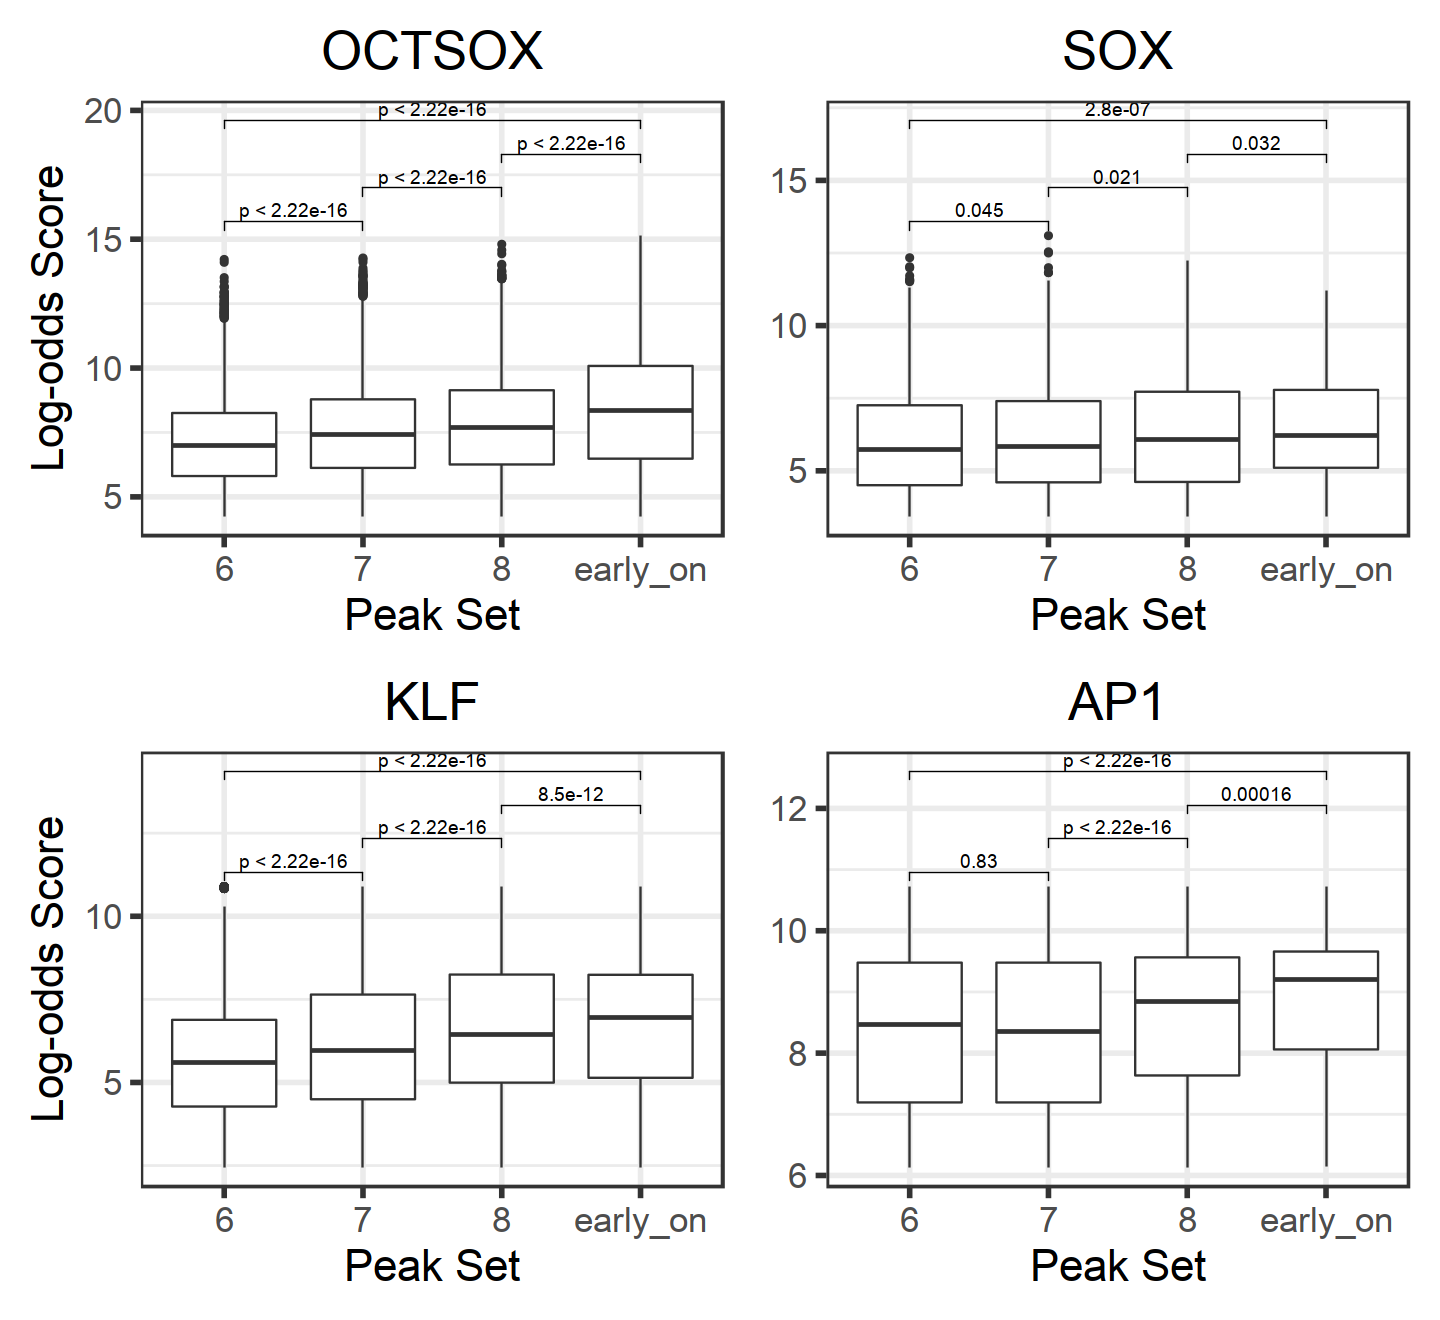

In [190]:
options(repr.plot.width = 12, repr.plot.height = 11)

p = (os_plot | sox_plot) / (klf_plot | ap1_plot)

p

In [161]:
ggsave("./subfigs/peak.x.aff.imp.threshold.raw.p.val.pdf", width=12, height=11)

In [139]:
pvals = c(2.22e-16, 2.22e-16, 2.22e-16,2.22e-16,  
          0.045, 0.021, 0.032, 2.8e-7,
          2.22e-16,2.22e-16,2.22e-16,8.5e-12, 
          0.83, 2.22e-16, 0.00016, 2.22e-16)
p.adjust(pvals, method = "BH")[1:4]
p.adjust(pvals, method = "BH")[5:8]
p.adjust(pvals, method = "BH")[9:12]
p.adjust(pvals, method = "BH")[13:16]

[1] 3.946667e-16 3.946667e-16 3.946667e-16 3.946667e-16

[1] 4.800000e-02 2.584615e-02 3.657143e-02 4.072727e-07

[1] 3.946667e-16 3.946667e-16 3.946667e-16 1.360000e-11

[1] 8.300000e-01 3.946667e-16 2.133333e-04 3.946667e-16

## Raw (not thresholded by importance)

In [162]:
os_df = get_tf_df(peak_sets_granges, raw_motif_hits[["OCTSOX"]])
sox_df = get_tf_df(peak_sets_granges, raw_motif_hits[["SOX.not.OCTSOX"]])
klf_df = get_tf_df(peak_sets_granges, raw_motif_hits[["KLF"]])
ap1_df = get_tf_df(peak_sets_granges, raw_motif_hits[["AP1.not.OCTSOX"]])

os_plot = plot_per_tf(os_df, COMPARE_LIST, title="OCTSOX")
sox_plot = plot_per_tf(sox_df, COMPARE_LIST, title="SOX", ylabel=F)
klf_plot = plot_per_tf(klf_df, COMPARE_LIST, title="KLF")
ap1_plot = plot_per_tf(ap1_df, COMPARE_LIST, title="AP1", ylabel=F)

In [163]:
options(repr.plot.width = 12, repr.plot.height = 11)

p = (os_plot | sox_plot) / (klf_plot | ap1_plot)

In [164]:
ggsave("./subfigs/peak.x.aff.not.imp.threshold.raw.p.val.pdf", width=12, height=11)